In [1]:
# University of Toronto
# Faculty of Information
# INF2178 
# Chi-shiun Yang 
# 1009916897 
# Mar 20, 2024 
# Assignment 3

import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import ancova
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd




# load data
df = pd.read_csv('INF2178_A3_data.csv')
df.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2


In [2]:
# add new columns to the dataframe
# falltotal and springtotal are the total of students' scores in fall and spring 
# calculated by adding the columns of reading, math, and general knowledge scores 
df["falltotal"] = df["fallreadingscore"] + df["fallmathscore"] + df["fallgeneralknowledgescore"]
df["springtotal"] = df["springreadingscore"] + df["springmathscore"] + df["springgeneralknowledgescore"]

# readingdifference, mathdifference, and generaldifference are the difference of the scores from spring to fall
df["readingdifference"] = df["springreadingscore"] - df["fallreadingscore"]
df["mathdifference"] = df["springmathscore"] - df["fallmathscore"]
df["generaldifference"] = df["springgeneralknowledgescore"] - df["fallgeneralknowledgescore"]

df.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup,falltotal,springtotal,readingdifference,mathdifference,generaldifference
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3,109.942,140.003,12.79,10.56,6.711
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3,133.407,179.839,32.68,14.49,-0.738
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3,97.358,102.532,-0.27,4.24,1.204
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2,71.544,96.772,1.57,11.68,11.978
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2,70.357,83.417,0.86,3.95,8.250


In [3]:
def run_ancova(df, dependent_col, covariate_col):
    # summary statistics for dependent variable group by incomegroup
    summary = df >> group_by(X.incomegroup) >> summarize(n=X[dependent_col].count(), mean=X[dependent_col].mean(), std=X[dependent_col].std())
    display(summary)

    # draw the scatter plot box plot of the columns
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    # the scatter plot of the dependent and covariate columns
    sns.scatterplot(data=df, x=covariate_col, y=dependent_col, hue=df.incomegroup.tolist(), hue_order = [1, 2, 3], ax=axs[0, 0], s=5, palette="tab10")
    # the regression line of dependent and covariate columns for each income group
    for i in range (1, 4):
        x = df[df["incomegroup"] == i][covariate_col]
        y = df[df["incomegroup"] == i][dependent_col]
        # the the linear regression line
        line = sm.OLS(y, sm.add_constant(x)).fit()
        # get the coefficeient and constant
        const, coef = line.params
        # plot the line
        y_pred = line.predict(sm.add_constant(x))
        axs[0, 1].plot(x, y_pred, label = str(i) + ": y={:.2f}x+{:.2f}".format(coef, const))
    # set the labels and legend of the subplot
    axs[0, 1].set_xlabel(covariate_col)
    axs[0, 1].set_ylabel(dependent_col)
    axs[0, 1].legend()
    # box plot of dependent_col for each income groups
    sns.boxplot(data=df, x="incomegroup", y=dependent_col, hue=df.incomegroup.tolist(), ax=axs[1, 0], order=[1, 2, 3], palette="tab10")
    # box plot of covariate_col for each income groups
    sns.boxplot(data=df, x="incomegroup", y=covariate_col, hue=df.incomegroup.tolist(), ax=axs[1, 1], order=[1, 2, 3], palette="tab10")
    plt.show()

    # run ANCOVA
    df_ancova = ancova(data=df, dv=dependent_col, covar=covariate_col, between='incomegroup')
    print("ANCOVA method 1")
    display(df_ancova)

    # Fit ANCOVA model
    model = sm.formula.ols(dependent_col + ' ~ incomegroup + ' + covariate_col, data=df).fit()

    print("ANCOVA method 2")
    display(sm.stats.anova_lm(model, typ=2))
    # Print model summary
    print(model.summary())
    print("\nP-value: ", model.pvalues[1])

    # if the p-value is less than 0.05
    if  model.pvalues[1] < 0.05:
        print("\nThe p-value is less than 0.05, we reject the null hypothesis.\n")
        # we apply a post hoc test with tukeyhsd
        print(pairwise_tukeyhsd(endog=df[dependent_col] , groups=df['incomegroup'], alpha=0.05))

    # checking assumtions
    # assumption 1: residuals are normally distributed
    # qq-plot 
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
    sm.qqplot(model.resid, line='45', ax=axs[0])
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    # plt.show()
    
    # histogram
    axs[1].hist(model.resid, bins=50, histtype='bar', ec='k')
    plt.xlabel("Residuals")
    plt.ylabel('Frequency')
    plt.show()
    
    # Shapiro Wilk test
    w, pvalue = stats.shapiro(model.resid)
    print("Shapiro Wilk test results: ")
    print(w, pvalue)

    # assumption 2: variances are homoegenous
    if pvalue > 0.05:
        # Bartlett's test when the sample is normally distributed
        res = stats.bartlett(df[df["incomegroup"] == 1][dependent_col], df[df["incomegroup"] == 2][dependent_col], df[df["incomegroup"] == 3][dependent_col])
        print("\nThe sample is normally distributed, Bartlett's test p-value: ", res.pvalue)
    else:
        # Levene's test when the sample is not normally distributed
        res = stats.levene(df[df["incomegroup"] == 1][dependent_col], df[df["incomegroup"] == 2][dependent_col], df[df["incomegroup"] == 3][dependent_col])
        print("\nThe sample is not normally distributed, Levene's test p-value: ", res.pvalue)
    

    


,incomegroup,n,mean,std
0,1,4729,43.665077,12.004821
1,2,3726,48.009450,13.505020
2,3,3478,52.206880,16.450153


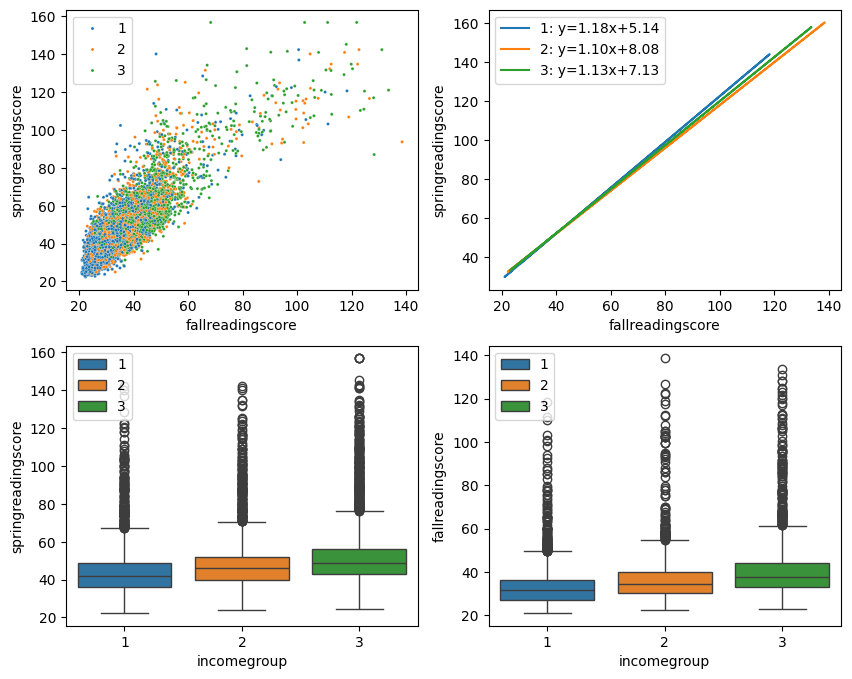

ANCOVA method 1


,Source,SS,DF,F,p-unc,np2
0,incomegroup,5.131201e+02,2,4.055660,0.017348,0.00068
1,fallreadingscore,1.547042e+06,1,24455.397576,0.000000,0.67214
2,Residual,7.546256e+05,11929,NaN,NaN,NaN


ANCOVA method 2


,sum_sq,df,F,PR(>F)
incomegroup,4.699812e+02,1.0,7.429586,0.006425
fallreadingscore,1.547013e+06,1.0,24455.584711,0.000000
Residual,7.546687e+05,11930.0,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:     springreadingscore   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                 1.339e+04
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:19:40   Log-Likelihood:                -41675.
No. Observations:               11933   AIC:                         8.336e+04
Df Residuals:                   11930   BIC:                         8.338e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.3272      0.280  

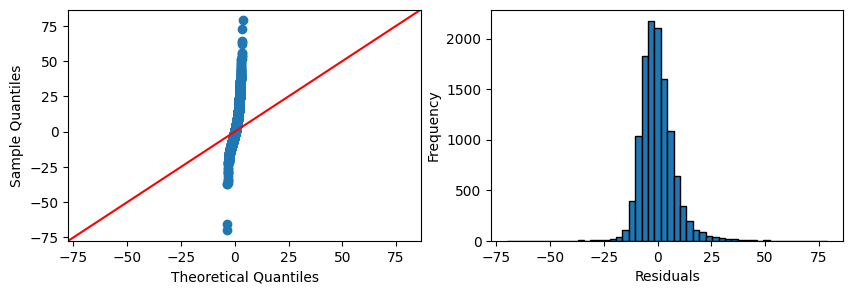

Shapiro Wilk test results: 
0.9120939373970032 0.0

The sample is not normally distributed, Levene's test p-value:  7.570499656193536e-18


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [4]:
# Research question 1 - reading score
run_ancova(df, 'springreadingscore', 'fallreadingscore')

,incomegroup,n,mean,std
0,1,4729,33.883051,10.734653
1,2,3726,38.464691,11.359349
2,3,3478,42.411898,12.605759


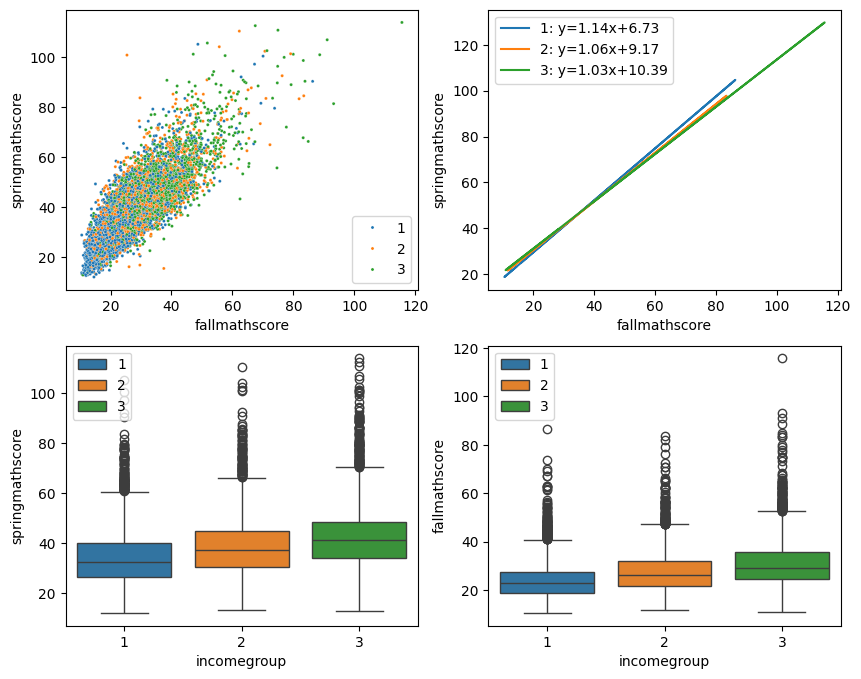

ANCOVA method 1


,Source,SS,DF,F,p-unc,np2
0,incomegroup,1.712758e+03,2,18.523585,9.284861e-09,0.003096
1,fallmathscore,1.026489e+06,1,22203.081238,0.000000e+00,0.650505
2,Residual,5.514994e+05,11929,NaN,NaN,NaN


ANCOVA method 2


,sum_sq,df,F,PR(>F)
incomegroup,1.600557e+03,1.0,34.616102,4.123521e-09
fallmathscore,1.026633e+06,1.0,22203.535082,0.000000e+00
Residual,5.516116e+05,11930.0,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:        springmathscore   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 1.270e+04
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:19:41   Log-Likelihood:                -39805.
No. Observations:               11933   AIC:                         7.962e+04
Df Residuals:                   11930   BIC:                         7.964e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7862      0.215     36.286

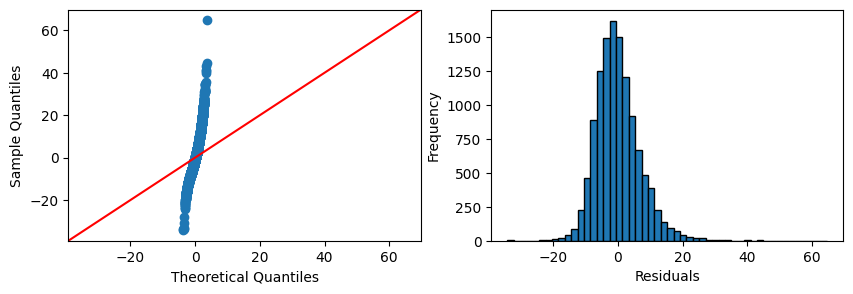

Shapiro Wilk test results: 
0.9649487137794495 0.0

The sample is not normally distributed, Levene's test p-value:  6.380804527269148e-09


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [5]:
# Research question 1 - math score
run_ancova(df, 'springmathscore', 'fallmathscore')

,incomegroup,n,mean,std
0,1,4729,25.069492,7.248229
1,2,3726,29.143605,6.965300
2,3,3478,31.567718,6.928347


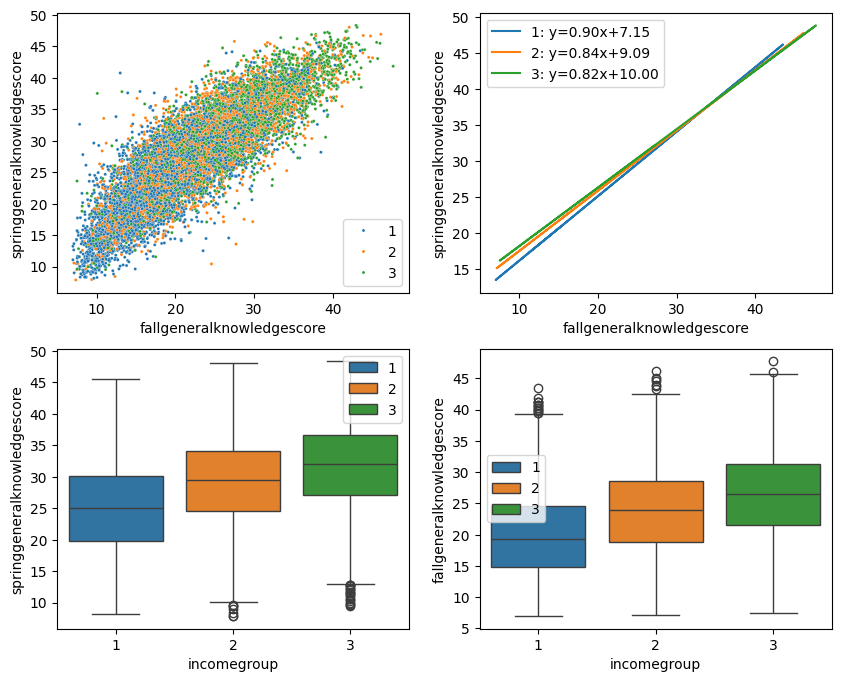

ANCOVA method 1


,Source,SS,DF,F,p-unc,np2
0,incomegroup,1756.904469,2,56.908040,2.525291e-25,0.009451
1,fallgeneralknowledgescore,411876.768316,1,26682.269841,0.000000e+00,0.691049
2,Residual,184140.179925,11929,NaN,NaN,NaN


ANCOVA method 2


,sum_sq,df,F,PR(>F)
incomegroup,1614.072508,1.0,104.490831,1.991221e-24
fallgeneralknowledgescore,413465.233250,1.0,26766.657340,0.000000e+00
Residual,184283.011886,11930.0,NaN,NaN


                                 OLS Regression Results                                
Dep. Variable:     springgeneralknowledgescore   R-squared:                       0.731
Model:                                     OLS   Adj. R-squared:                  0.731
Method:                          Least Squares   F-statistic:                 1.621e+04
Date:                         Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                                 09:19:42   Log-Likelihood:                -33263.
No. Observations:                        11933   AIC:                         6.653e+04
Df Residuals:                            11930   BIC:                         6.656e+04
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

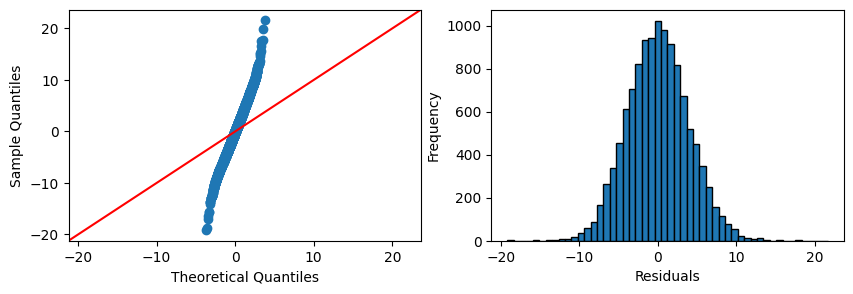

Shapiro Wilk test results: 
0.9980876445770264 4.9229818138707415e-11

The sample is not normally distributed, Levene's test p-value:  8.286000485876772e-05


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [6]:
# Research question 1 - general knowledge score
run_ancova(df, 'springgeneralknowledgescore', 'fallgeneralknowledgescore')

,incomegroup,n,mean,std
0,1,4729,102.617621,25.765455
1,2,3726,115.617746,26.888682
2,3,3478,126.186496,30.240616


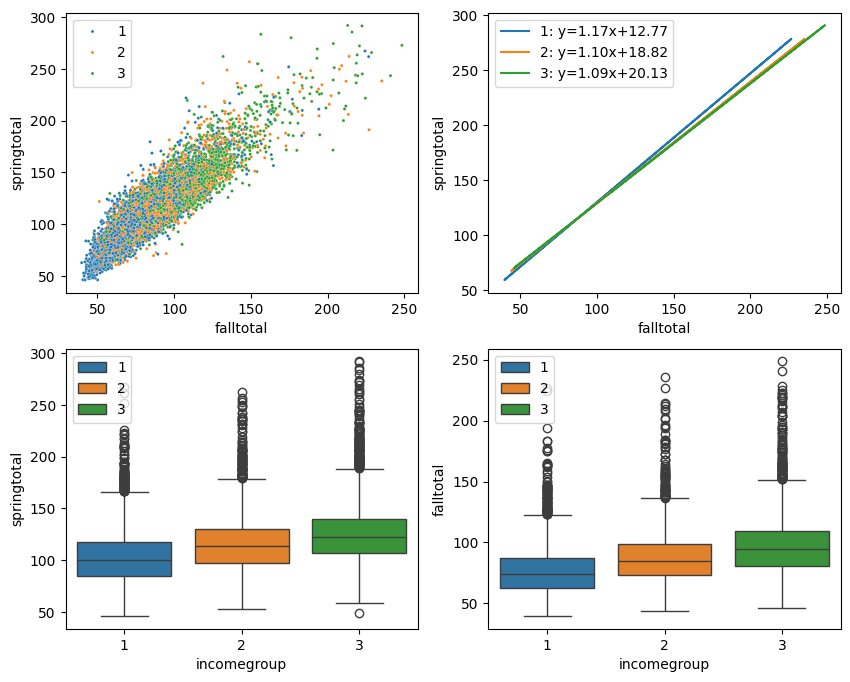

ANCOVA method 1


,Source,SS,DF,F,p-unc,np2
0,incomegroup,7.012567e+02,2,2.054860,0.128156,0.000344
1,falltotal,6.976113e+06,1,40883.557448,0.000000,0.774126
2,Residual,2.035489e+06,11929,NaN,NaN,NaN


ANCOVA method 2


,sum_sq,df,F,PR(>F)
incomegroup,3.151617e+02,1.0,1.846812,0.17418
falltotal,6.979486e+06,1.0,40898.997295,0.00000
Residual,2.035875e+06,11930.0,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:            springtotal   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                 2.377e+04
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:19:43   Log-Likelihood:                -47596.
No. Observations:               11933   AIC:                         9.520e+04
Df Residuals:                   11930   BIC:                         9.522e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.6774      0.475     35.110      

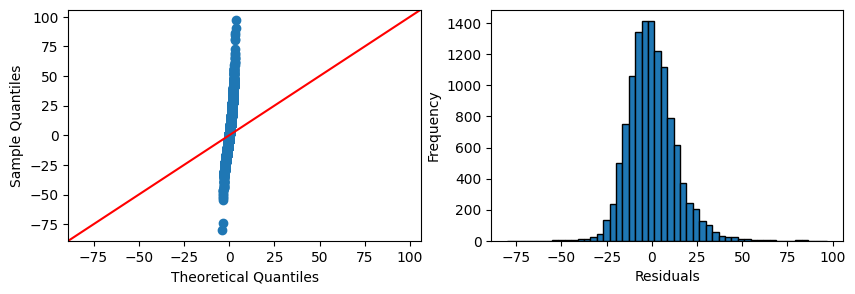

Shapiro Wilk test results: 
0.9715730547904968 3.433181237595802e-43

The sample is not normally distributed, Levene's test p-value:  2.0621812350995604e-06


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [7]:
# Research question 2 - total score
run_ancova(df, 'springtotal', 'falltotal')

,incomegroup,n,mean,std
0,1,4729,10.878279,7.462176
1,2,3726,11.716932,7.906122
2,3,3478,12.308387,8.967606


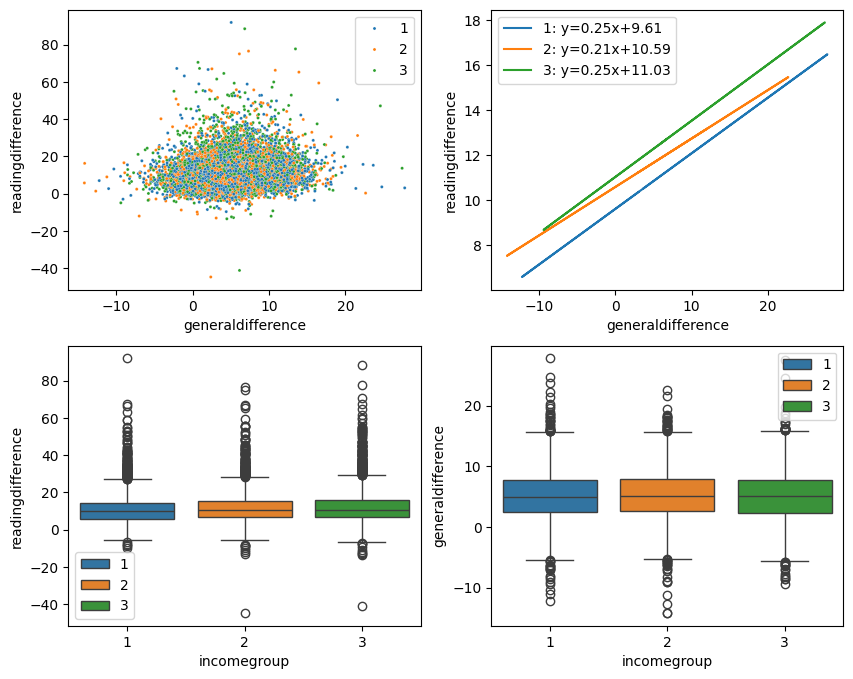

ANCOVA method 1


,Source,SS,DF,F,p-unc,np2
0,incomegroup,4209.528531,2,32.835548,6.009132e-15,0.005475
1,generaldifference,11074.220434,1,172.764288,3.448471e-39,0.014276
2,Residual,764650.940643,11929,NaN,NaN,NaN


ANCOVA method 2


,sum_sq,df,F,PR(>F)
incomegroup,4188.434969,1.0,65.34570,6.889410e-16
generaldifference,11091.986381,1.0,173.05118,2.991198e-39
Residual,764672.034205,11930.0,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:      readingdifference   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     119.3
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           5.12e-52
Time:                        09:19:44   Log-Likelihood:                -41754.
No. Observations:               11933   AIC:                         8.351e+04
Df Residuals:                   11930   BIC:                         8.354e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.9648      0.20

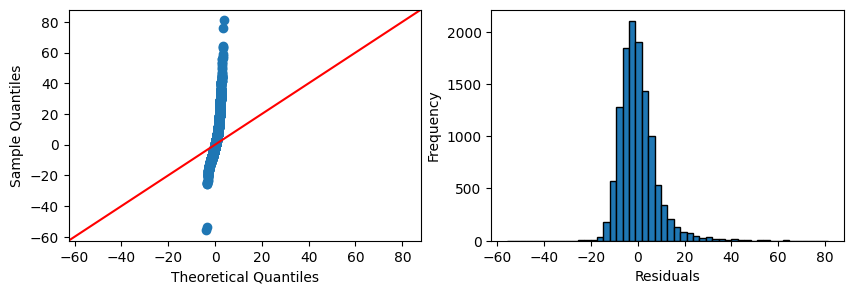

Shapiro Wilk test results: 
0.8929216265678406 0.0

The sample is not normally distributed, Levene's test p-value:  2.794929503613517e-09


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
# Research question 3 - reading score
run_ancova(df, 'readingdifference', 'generaldifference')


,incomegroup,n,mean,std
0,1,4729,9.958547,6.406540
1,2,3726,10.896224,6.853736
2,3,3478,11.399178,7.339003


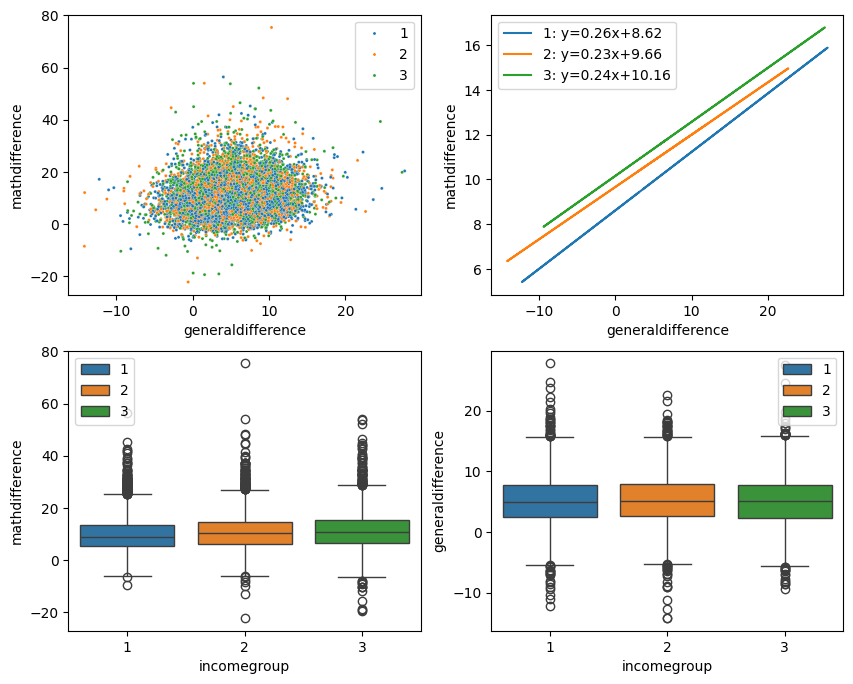

ANCOVA method 1


,Source,SS,DF,F,p-unc,np2
0,incomegroup,4388.326834,2,48.089207,1.580759e-21,0.007998
1,generaldifference,12022.654936,1,263.499036,1.257053e-58,0.021612
2,Residual,544283.777802,11929,NaN,NaN,NaN


ANCOVA method 2


,sum_sq,df,F,PR(>F)
incomegroup,4302.722116,1.0,94.295301,3.284278e-22
generaldifference,12057.229186,1.0,264.237389,8.746819e-59
Residual,544369.382519,11930.0,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:         mathdifference   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     179.4
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.75e-77
Time:                        09:19:45   Log-Likelihood:                -39726.
No. Observations:               11933   AIC:                         7.946e+04
Df Residuals:                   11930   BIC:                         7.948e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.0082      0.17

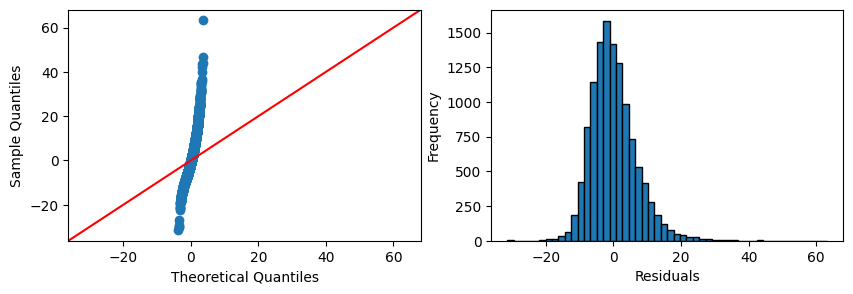

Shapiro Wilk test results: 
0.9583078026771545 0.0

The sample is not normally distributed, Levene's test p-value:  2.344180384098772e-10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
# Research question 3 - math score
run_ancova(df, 'mathdifference', 'generaldifference')

